# Deep learning examples

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/etna-team/etna/master?filepath=examples/202-NN_examples.ipynb)

This notebooks contains examples with neural network models.

**Table of contents**

* [Loading dataset](#chapter1)  
* [Architecture](#chapter2)
* [Testing models](#chapter3)
    * [Baseline](#section_3_1)
    * [DeepAR](#section_3_2)
    * [RNN](#section_3_4)
    * [Deep State Model](#section_3_5)
    * [N-BEATS Model](#section_3_6)
    * [PatchTS Model](#section_3_7)

In [34]:
# !pip install "etna[torch]" -q

In [35]:
import warnings

warnings.filterwarnings("ignore")

In [19]:
import random

import numpy as np
import pandas as pd
import torch

from etna.analysis import plot_backtest
from etna.datasets.tsdataset import TSDataset
from etna.metrics import MAE
from etna.metrics import MAPE
from etna.metrics import SMAPE
from etna.models import SeasonalMovingAverageModel
from etna.pipeline import Pipeline
from etna.transforms import DateFlagsTransform
from etna.transforms import LagTransform
from etna.transforms import LinearTrendTransform


metrics = [SMAPE(), MAPE(), MAE()]

In [15]:
def set_seed(seed: int = 42):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

## 1. Loading dataset <a class="anchor" id="chapter1"></a>

We are going to take some toy dataset. Let's load and look at it.

In [16]:
original_df = pd.read_csv("../Data/example_dataset.csv")
original_df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


Our library works with the special data structure `TSDataset`. Let's create it as it was done in "Get started" notebook.

In [17]:
df = TSDataset.to_dataset(original_df)
ts = TSDataset(df, freq="D")
ts.head(5)

segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-01-01,170,102,92,238
2019-01-02,243,123,107,358
2019-01-03,267,130,103,366
2019-01-04,287,138,103,385
2019-01-05,279,137,104,384


## 2. Architecture <a class="anchor" id="chapter2"></a>

Our library has two types of models:

- Models from [PyTorch Forecasting](https://github.com/jdb78/pytorch-forecasting)
- Native models.

First, let's describe the `pytorch-forecasting` models, because they require a special handling. There are two ways to use these models: default one and via using `PytorchForecastingDatasetBuilder` for using extra features. 

To include extra features we use `PytorchForecastingDatasetBuilder` class.

Let's look at it closer.

In [40]:
from etna.models.nn.utils import PytorchForecastingDatasetBuilder

In [41]:
?PytorchForecastingDatasetBuilder

Init signature:
PytorchForecastingDatasetBuilder(
    max_encoder_length: int = 30,
    min_encoder_length: Optional[int] = None,
    min_prediction_idx: Optional[int] = None,
    min_prediction_length: Optional[int] = None,
    max_prediction_length: int = 1,
    static_categoricals: Optional[List[str]] = None,
    static_reals: Optional[List[str]] = None,
    time_varying_known_categoricals: Optional[List[str]] = None,
    time_varying_known_reals: Optional[List[str]] = None,
    time_varying_unknown_categoricals: Optional[List[str]] = None,
    time_varying_unknown_reals: Optional[List[str]] = None,
    variable_groups: Optional[Dict[str, List[int]]] = None,
    constant_fill_strategy: Optional[Dict[str, Union[str, float, int, bool]]] = None,
    allow_missing_timesteps: bool = True,
    lags: Optional[Dict[str, List[int]]] = None,
    add_relative_time_idx: bool = True,
    add_target_scales: bool = True,
    add_encoder_length: Union[bool, str] = True,
    target_normalizer: Union

We can see a pretty scary signature, but don't panic, we will look at the most important parameters. 

* `time_varying_known_reals` &mdash; known real values that change across the time (real regressors), now it it necessary to add "time_idx" variable to the list;
* `time_varying_unknown_reals` &mdash; our real value target, set it to `["target"]`;
* `max_prediction_length` &mdash; our horizon for forecasting;
* `max_encoder_length` &mdash; length of past context to use;
* `static_categoricals` &mdash; static categorical values, for example, if we use multiple segments it can be some its characteristics including identifier: "segment";
* `time_varying_known_categoricals` &mdash; known categorical values that change across the time (categorical regressors);
* `target_normalizer` &mdash; class for normalization targets across different segments.

Our library currently supports these `pytorch-forecasting` models:

* [DeepAR](https://arxiv.org/abs/1704.04110) (will be removed in version 3.0),
* [TFT](https://arxiv.org/abs/1912.09363).

As for the native neural network models, they are simpler to use, because they don't require `PytorchForecastingTransform`. We will see how to use them on examples.

## 3. Testing models <a class="anchor" id="chapter3"></a>

In this section we will test our models on example.

In [9]:
HORIZON = 7
metrics = [SMAPE(), MAPE(), MAE()]

### 3.1 Baseline <a class="anchor" id="section_3_1"></a>

For comparison let's train some simple model as a baseline.

In [43]:
model_sma = SeasonalMovingAverageModel(window=5, seasonality=7)
linear_trend_transform = LinearTrendTransform(in_column="target")

pipeline_sma = Pipeline(model=model_sma, horizon=HORIZON, transforms=[linear_trend_transform])

In [44]:
metrics_sma, forecast_sma, fold_info_sma = pipeline_sma.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0

In [45]:
metrics_sma

,segment,SMAPE,MAPE,MAE,fold_number
0,segment_a,6.343943,6.124296,33.196532,0
0,segment_a,5.346946,5.192455,27.938101,1
0,segment_a,7.510347,7.189999,40.028565,2
1,segment_b,7.178822,6.920176,17.818102,0
1,segment_b,5.672504,5.554555,13.719200,1
1,segment_b,3.327846,3.359712,7.680919,2
2,segment_c,6.430429,6.200580,10.877718,0
2,segment_c,5.947090,5.727531,10.701336,1
2,segment_c,6.186545,5.943679,11.359563,2
3,segment_d,4.707899,4.644170,39.918646,0


In [46]:
score = metrics_sma["SMAPE"].mean()
print(f"Average SMAPE for Seasonal MA: {score:.3f}")

Average SMAPE for Seasonal MA: 5.547


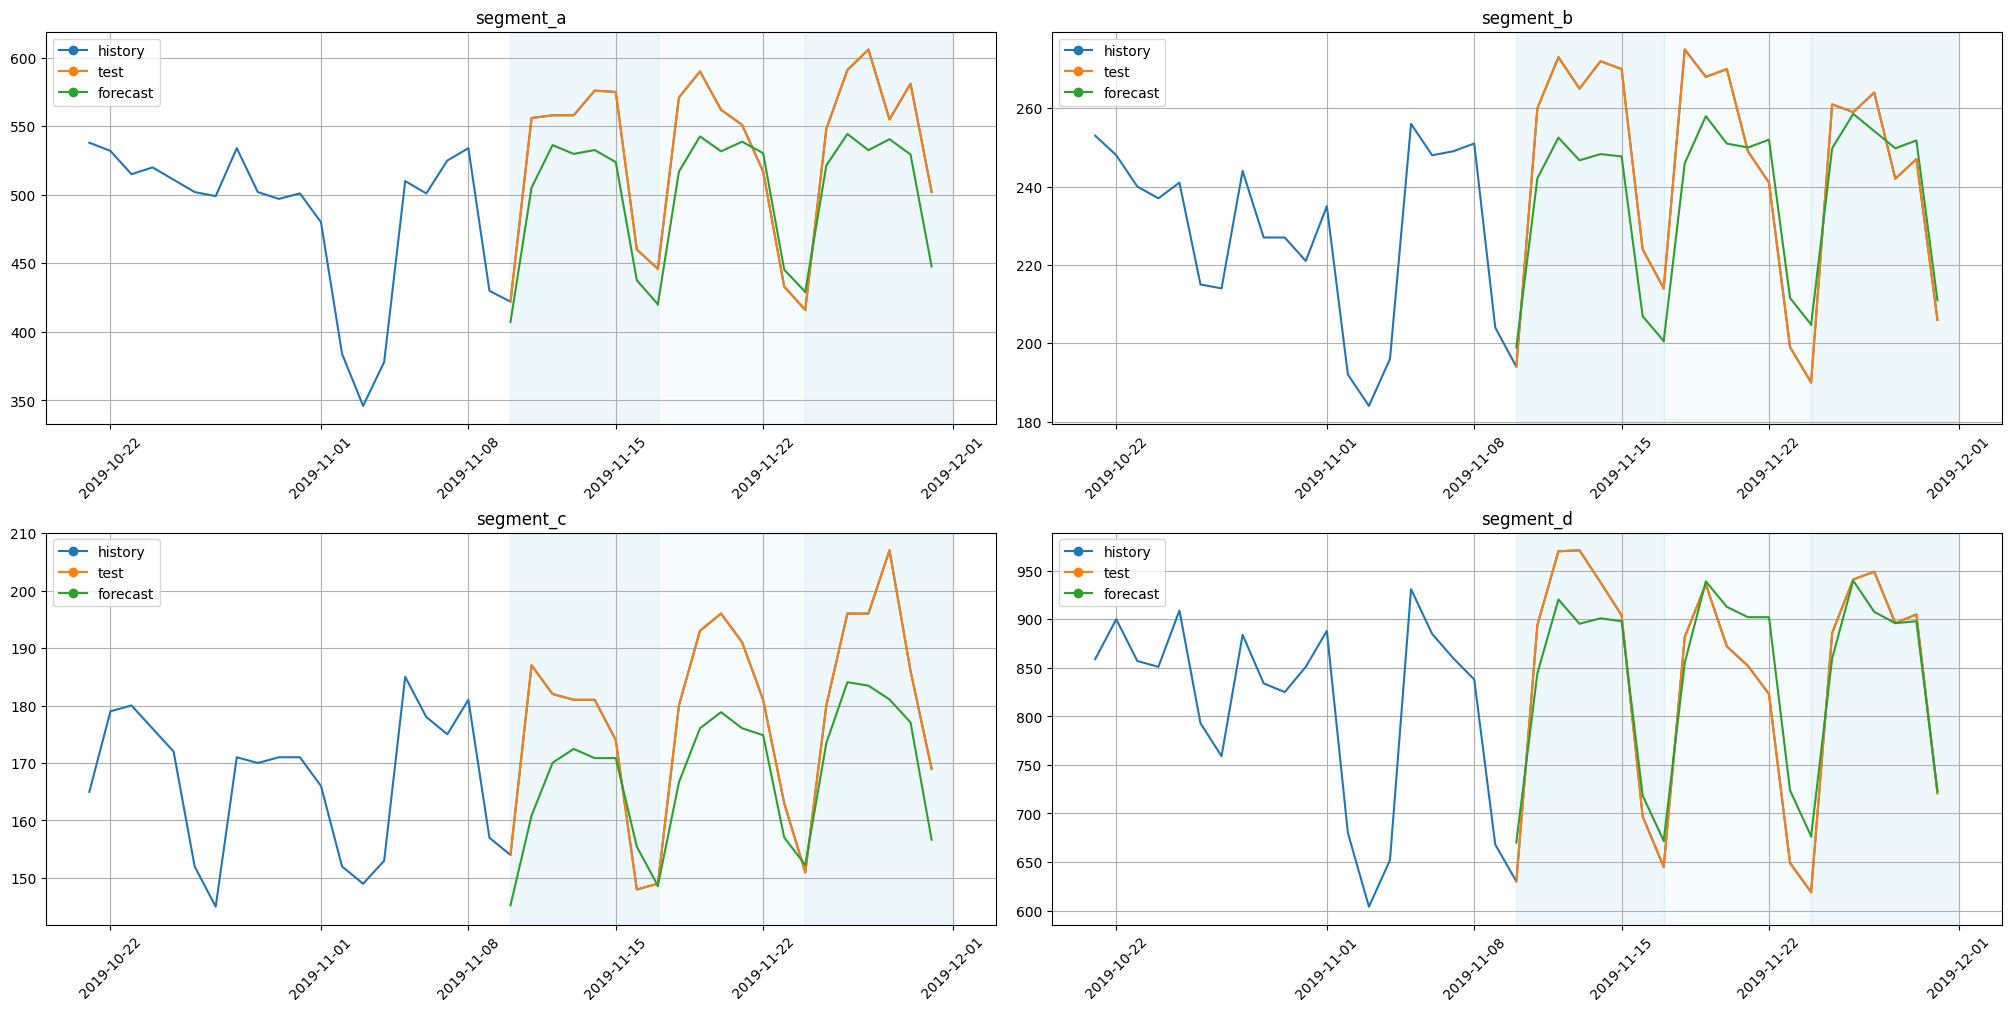

In [47]:
plot_backtest(forecast_sma, ts, history_len=20)

### 3.2 DeepAR <a class="anchor" id="section_3_2"></a>

In [48]:
from etna.models.nn import DeepARModel

Before training let's fix seeds for reproducibility.

In [49]:
set_seed()

#### Default way

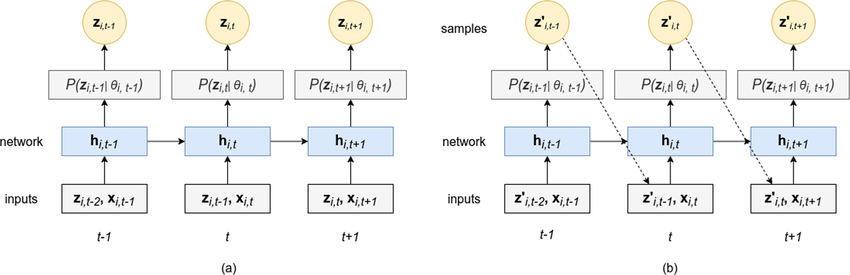

https://arxiv.org/abs/1704.04110

In [50]:
model_deepar = DeepARModel(
    encoder_length=HORIZON,
    decoder_length=HORIZON,
    trainer_params=dict(max_epochs=150, gpus=0, gradient_clip_val=0.1),
    lr=0.01,
    train_batch_size=64,
)
metrics = [SMAPE(), MAPE(), MAE()]

pipeline_deepar = Pipeline(model=model_deepar, horizon=HORIZON)

In [51]:
metrics_deepar, forecast_deepar, fold_info_deepar = pipeline_deepar.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 1.6 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 1.6 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [ ]:
metrics_deepar

,segment,SMAPE,MAPE,MAE,fold_number
0,segment_a,11.457985,10.746764,58.296596,0
0,segment_a,3.176019,3.188004,16.515852,1
0,segment_a,7.292166,7.075430,38.055638,2
1,segment_b,8.014023,7.647102,20.117395,0
1,segment_b,4.404579,4.387297,10.633220,1
1,segment_b,5.720607,6.126162,13.026145,2
2,segment_c,6.136967,6.092227,10.315159,0
2,segment_c,4.311422,4.218119,7.638395,1
2,segment_c,9.405841,9.125036,16.484007,2
3,segment_d,5.807082,5.653967,50.962088,0


To summarize it we will take mean value of SMAPE metric because it is scale tolerant.

In [ ]:
score = metrics_deepar["SMAPE"].mean()
print(f"Average SMAPE for DeepAR: {score:.3f}")

Average SMAPE for DeepAR: 6.184


### 3.3 DeepARNative <a class="anchor" id="section_3_3"></a>

It is recommended to use our native implementation of DeepAR, we will remove Pytorch Forecasting version in etna 3.0.0.

In [1]:
from etna.models.nn import DeepARNativeModel
from etna.transforms import StandardScalerTransform

In [12]:
set_seed()

std = StandardScalerTransform(in_column="target")

model_deepar_native = DeepARNativeModel(
    input_size=1,
    encoder_length=2 * HORIZON,
    decoder_length=HORIZON,
    lr=0.01,
    scale=False,
    n_samples=100,
    train_batch_size=64,
    trainer_params=dict(max_epochs=30, gpus=0, gradient_clip_val=0.1),
)

pipeline_deepar_native = Pipeline(model=model_deepar_native, horizon=HORIZON, transforms=[std])

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(


In [20]:
metrics_deepar_native, forecast_deepar_native, fold_info_deepar_native = pipeline_deepar_native.backtest(
    ts, metrics=metrics, n_folds=3, n_jobs=1
)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(


/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/lightning_fabric/accelerators/cuda.py:235: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /mnt/batch/tasks/shared/LS_root/mounts/clusters/apodkidyshev-8cpu/code/Users/apodkidyshev/Personal/lesson 3/c

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   45.5s remaining:    0.0s
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /mnt/batch

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /mnt/batch

Training: 0it [00:00, ?it/s]

In [ ]:
score = metrics_deepar_native["SMAPE"].mean()
print(f"Average SMAPE for DeepARNative: {score:.3f}")

Average SMAPE for DeepARNative: 6.646


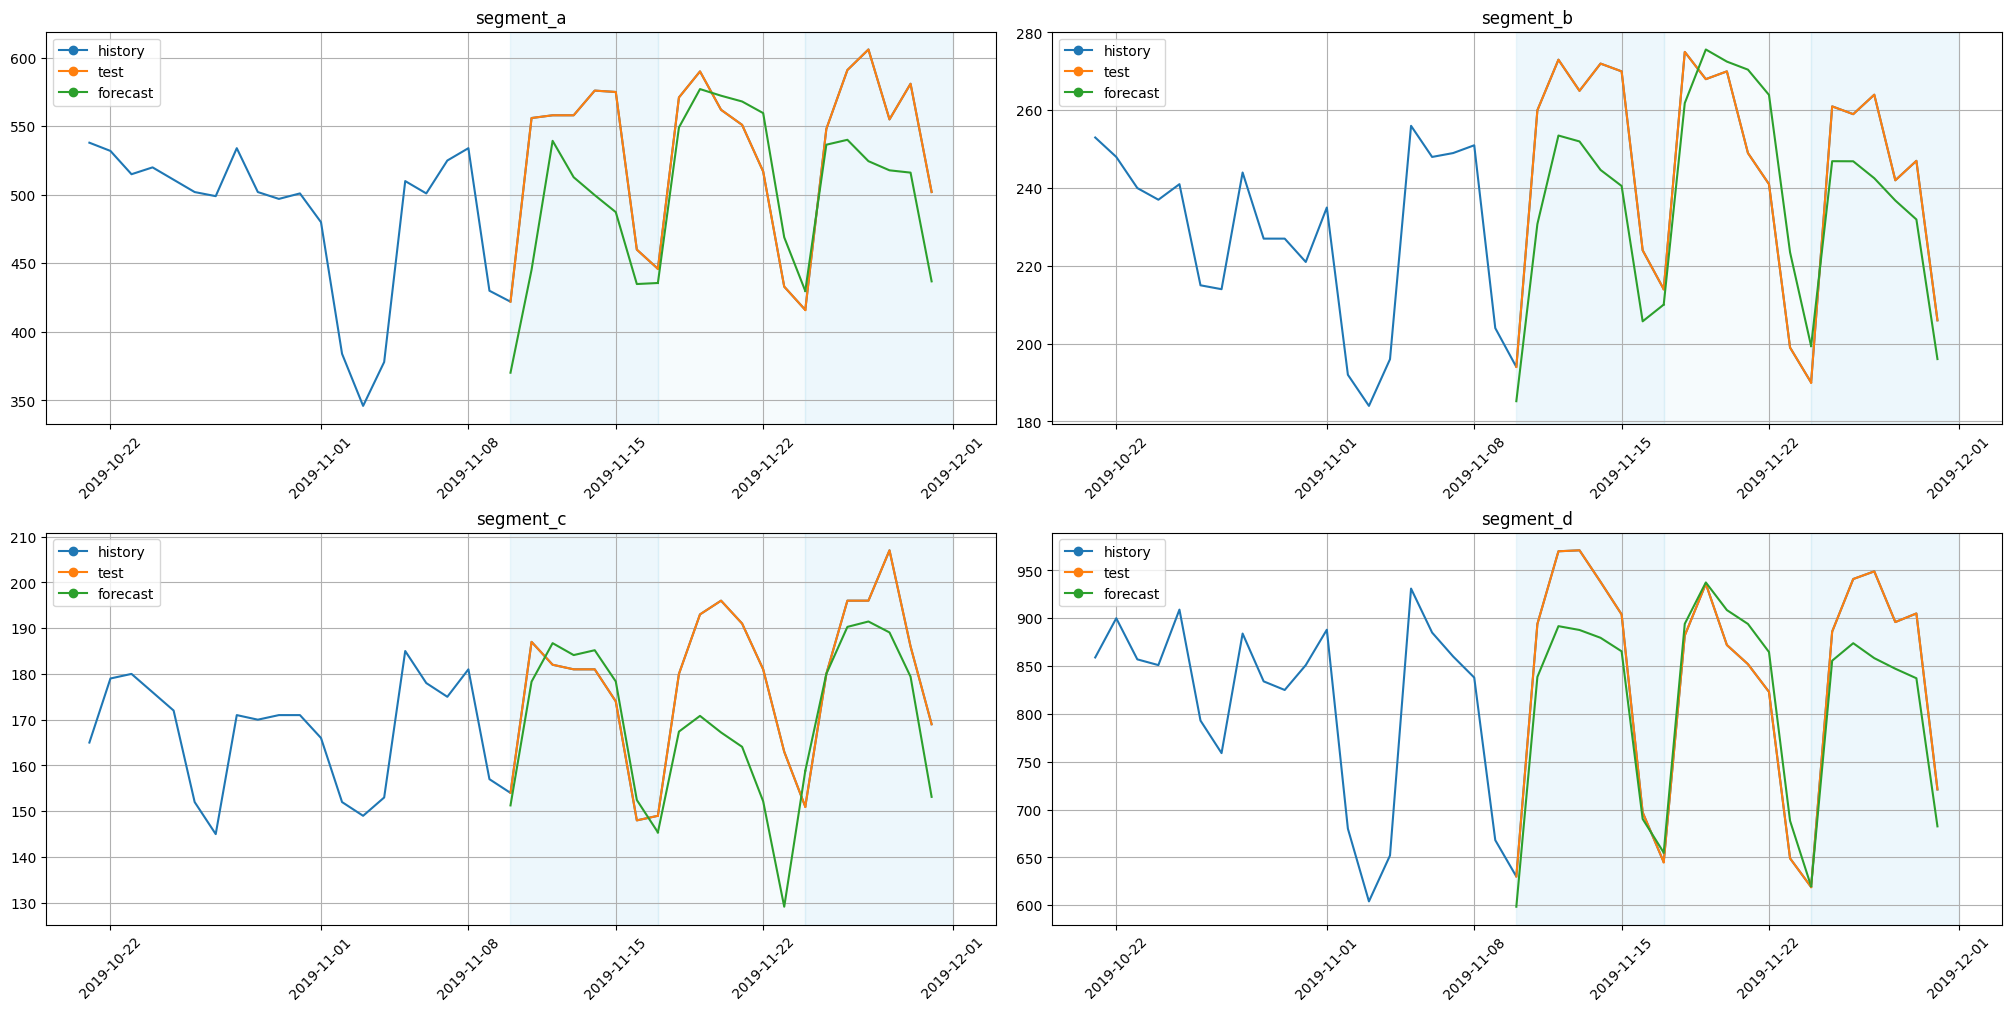

In [ ]:
plot_backtest(forecast_deepar_native, ts, history_len=20)

### 3.5 TFT <a class="anchor" id="section_3_3"></a>

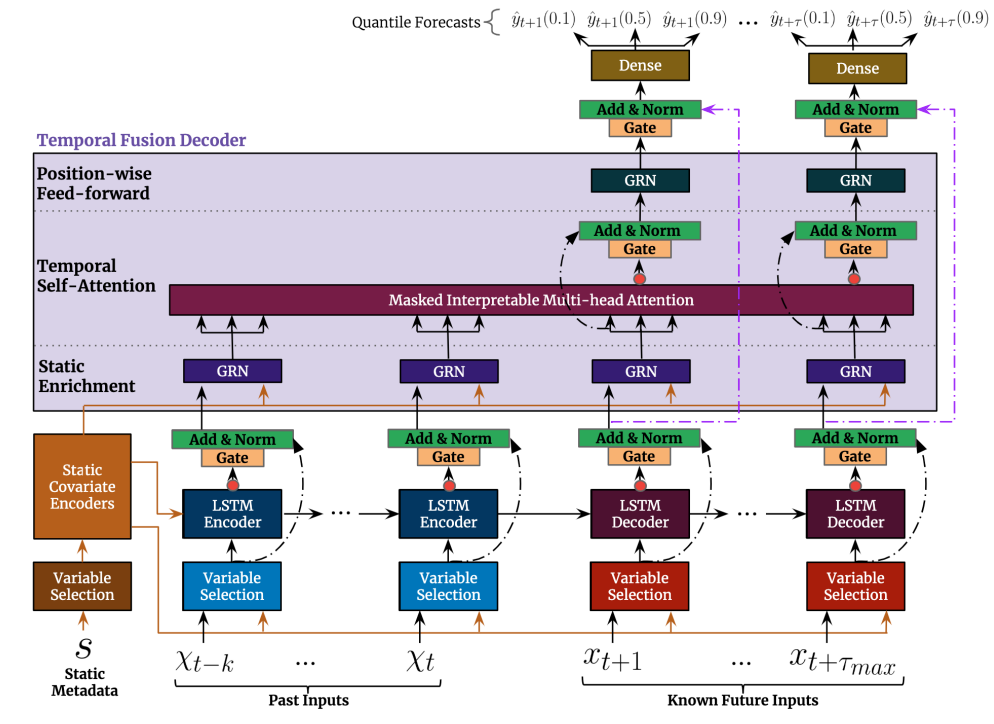

https://arxiv.org/abs/1912.09363

Let's move to the next model.

In [ ]:
from etna.models.nn import TFTModel

In [ ]:
set_seed()

#### Default way

In [ ]:
model_tft = TFTModel(
    encoder_length=HORIZON,
    decoder_length=HORIZON,
    trainer_params=dict(max_epochs=200, gpus=0, gradient_clip_val=0.1),
    lr=0.01,
    train_batch_size=64,
)

pipeline_tft = Pipeline(
    model=model_tft,
    horizon=HORIZON,
)

In [ ]:
metrics_tft, forecast_tft, fold_info_tft = pipeline_tft.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers             

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.8min remaining:    0.0s
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding       

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 11.5min remaining:    0.0s
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding       

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 17.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 17.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


In [ ]:
metrics_tft

,segment,SMAPE,MAPE,MAE,fold_number
0,segment_a,38.870241,32.158443,174.933677,0
0,segment_a,17.728181,15.791807,88.375493,1
0,segment_a,7.521734,7.236187,40.222752,2
1,segment_b,34.625996,43.168511,103.209172,0
1,segment_b,56.988057,81.425055,193.515682,1
1,segment_b,2.669728,2.715819,6.102428,2
2,segment_c,69.266956,106.987150,181.923475,0
2,segment_c,84.228787,147.457173,259.670846,1
2,segment_c,9.052672,8.962155,16.354137,2
3,segment_d,81.622394,57.610885,503.362261,0


In [ ]:
score = metrics_tft["SMAPE"].mean()
print(f"Average SMAPE for TFT: {score:.3f}")

Average SMAPE for TFT: 40.191


#### Dataset Builder

In [ ]:
# set_seed()

# transform_date = DateFlagsTransform(day_number_in_week=True, day_number_in_month=False, out_column="dateflag")
# num_lags = 10
# transform_lag = LagTransform(
#     in_column="target",
#     lags=[HORIZON + i for i in range(num_lags)],
#     out_column="target_lag",
# )
# lag_columns = [f"target_lag_{HORIZON+i}" for i in range(num_lags)]

# dataset_builder_tft = PytorchForecastingDatasetBuilder(
#     max_encoder_length=HORIZON,
#     max_prediction_length=HORIZON,
#     time_varying_known_reals=["time_idx"],
#     time_varying_unknown_reals=["target"],
#     time_varying_known_categoricals=["dateflag_day_number_in_week"],
#     static_categoricals=["segment"],
#     target_normalizer=GroupNormalizer(groups=["segment"]),
# )

In [ ]:
# model_tft = TFTModel(
#     dataset_builder=dataset_builder_tft,
#     trainer_params=dict(max_epochs=200, gpus=0, gradient_clip_val=0.1),
#     lr=0.01,
#     train_batch_size=64,
# )

# pipeline_tft = Pipeline(
#     model=model_tft,
#     horizon=HORIZON,
#     transforms=[transform_lag, transform_date],
# )

In [ ]:
transform_date = DateFlagsTransform(day_number_in_week=True, day_number_in_month=False, out_column="dateflag")
num_lags = 10
transform_lag = LagTransform(
    in_column="target",
    lags=[HORIZON + i for i in range(num_lags)],
    out_column="target_lag",
)
lag_columns = [f"target_lag_{HORIZON+i}" for i in range(num_lags)]


model_tft = TFTModel(
    encoder_length=HORIZON,
    decoder_length=HORIZON,
    trainer_params=dict(max_epochs=200, gpus=0, gradient_clip_val=0.1),
    lr=0.01,
    train_batch_size=64,
)

pipeline_tft = Pipeline(
    model=model_tft,
    horizon=HORIZON,
    transforms=[transform_lag, transform_date],
)

In [ ]:
metrics_tft, forecast_tft, fold_info_tft = pipeline_tft.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 47    
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.9min remaining:    0.0s
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding       

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 12.2min remaining:    0.0s
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding       

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 18.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 18.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


In [ ]:
metrics_tft

,segment,SMAPE,MAPE,MAE,fold_number
0,segment_a,4.148834,4.048117,21.675973,0
0,segment_a,7.725891,7.659492,39.868892,1
0,segment_a,5.053913,4.863608,28.101632,2
1,segment_b,7.570723,7.235979,18.964552,0
1,segment_b,6.533405,6.388350,15.905797,1
1,segment_b,3.904501,3.962381,9.085181,2
2,segment_c,4.333469,4.256533,7.473284,0
2,segment_c,5.693175,5.523561,10.136538,1
2,segment_c,8.369295,8.021082,15.114441,2
3,segment_d,9.093395,9.081034,75.480913,0


In [ ]:
score = metrics_tft["SMAPE"].mean()
print(f"Average SMAPE for TFT: {score:.3f}")

Average SMAPE for TFT: 5.893


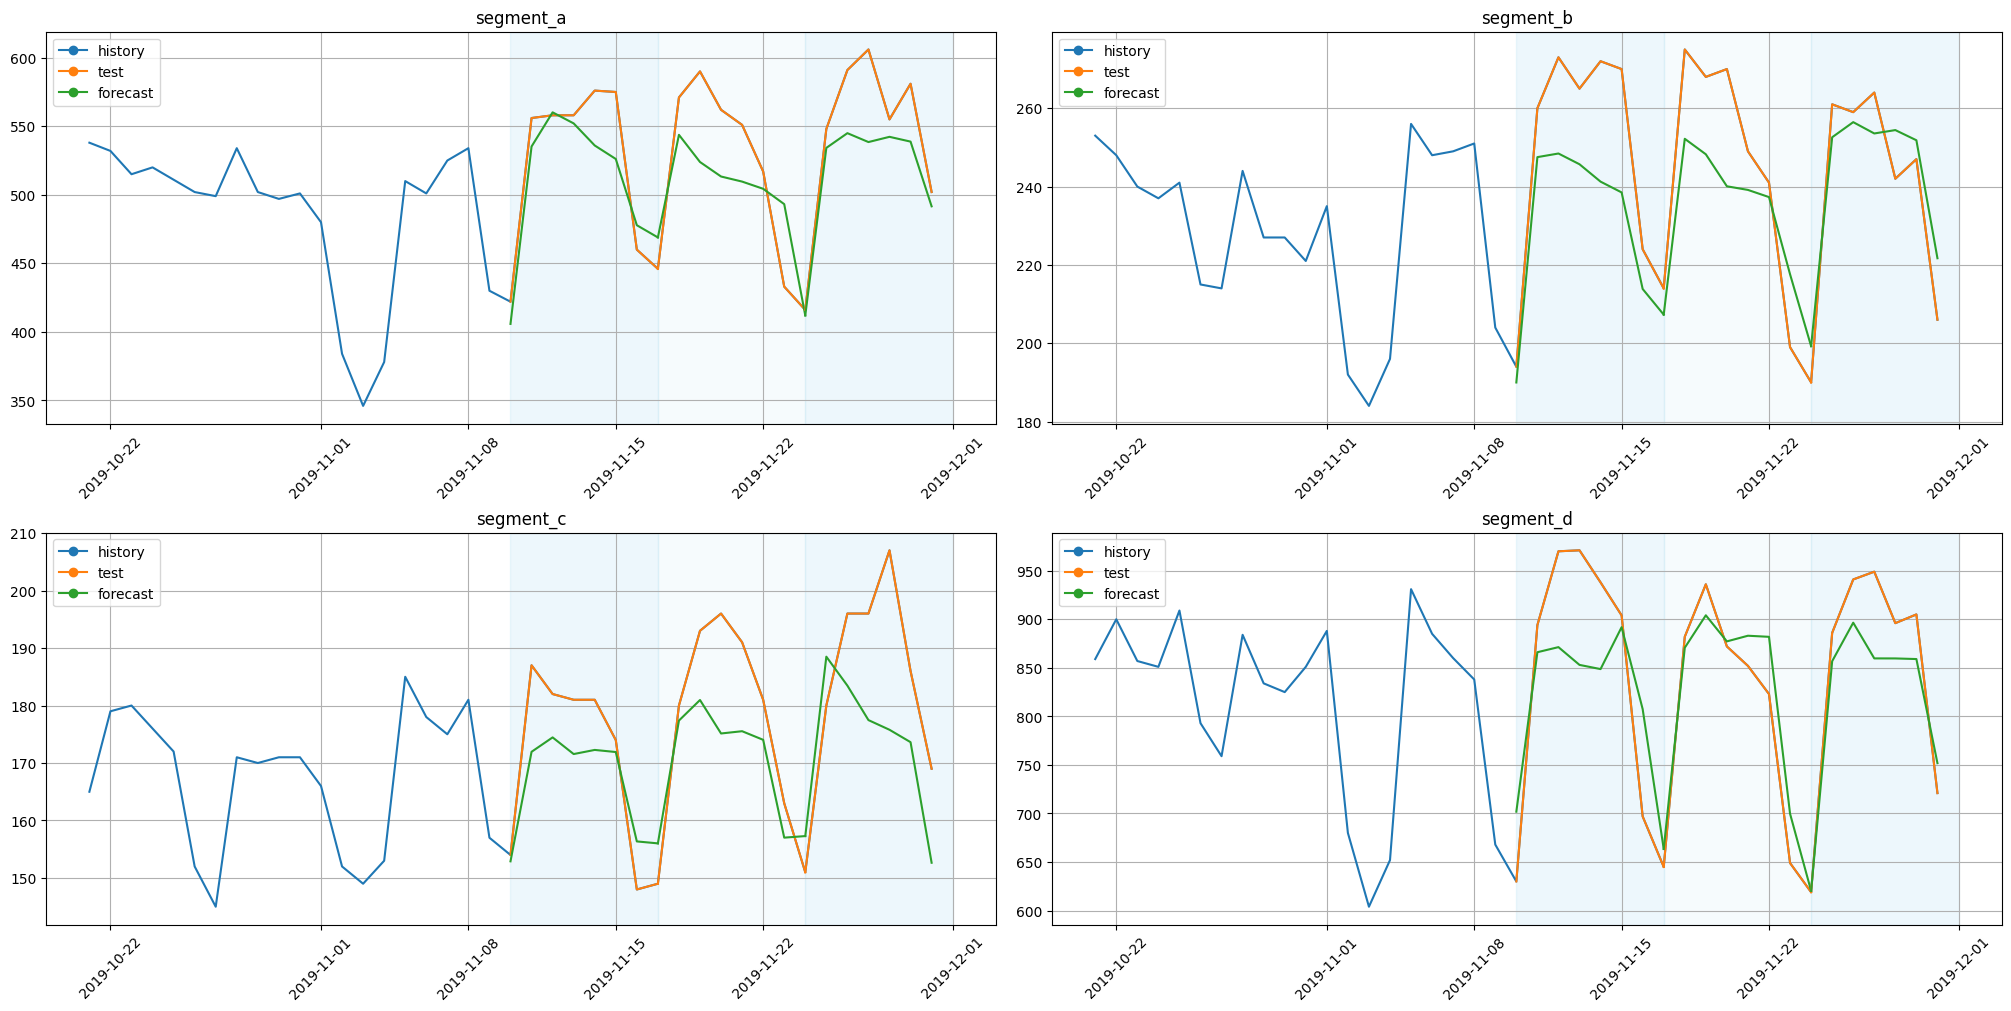

In [ ]:
plot_backtest(forecast_tft, ts, history_len=20)

### 3.6 RNN <a class="anchor" id="section_3_4"></a>

We'll use RNN model based on LSTM cell

In [ ]:
from etna.models.nn import RNNModel
from etna.transforms import StandardScalerTransform

In [ ]:
model_rnn = RNNModel(
    decoder_length=HORIZON,
    encoder_length=2 * HORIZON,
    input_size=11,
    trainer_params=dict(max_epochs=5),
    lr=1e-3,
)

pipeline_rnn = Pipeline(
    model=model_rnn,
    horizon=HORIZON,
    transforms=[StandardScalerTransform(in_column="target"), transform_lag],
)

In [ ]:
metrics_rnn, forecast_rnn, fold_info_rnn = pipeline_rnn.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type    | Params
---------------------------------------
0 | loss       | MSELoss | 0     
1 | rnn        | LSTM    | 4.0 K 
2 | projection | Linear  | 17    
---------------------------------------
4.0 K     Trainable params
0         Non-trainable params
4.0 K     Total params
0.016     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type    | Params
---------------------------------------
0 | loss       | MSELoss | 0     
1 | rnn        | LSTM    | 4.0 K 
2 | projection | Linear  | 17    
---------------------------------------
4.0 K     Trainable params
0         Non-trainable params
4.0 K     Total params
0.016     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.5s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type    | Params
---------------------------------------
0 | loss       | MSELoss | 0     
1 | rnn        | LSTM    | 4.0 K 
2 | projection | Linear  | 17    
---------------------------------------
4.0 K     Trainable params
0         Non-trainable params
4.0 K     Total params
0.016     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


In [ ]:
score = metrics_rnn["SMAPE"].mean()
print(f"Average SMAPE for LSTM: {score:.3f}")

Average SMAPE for LSTM: 5.643


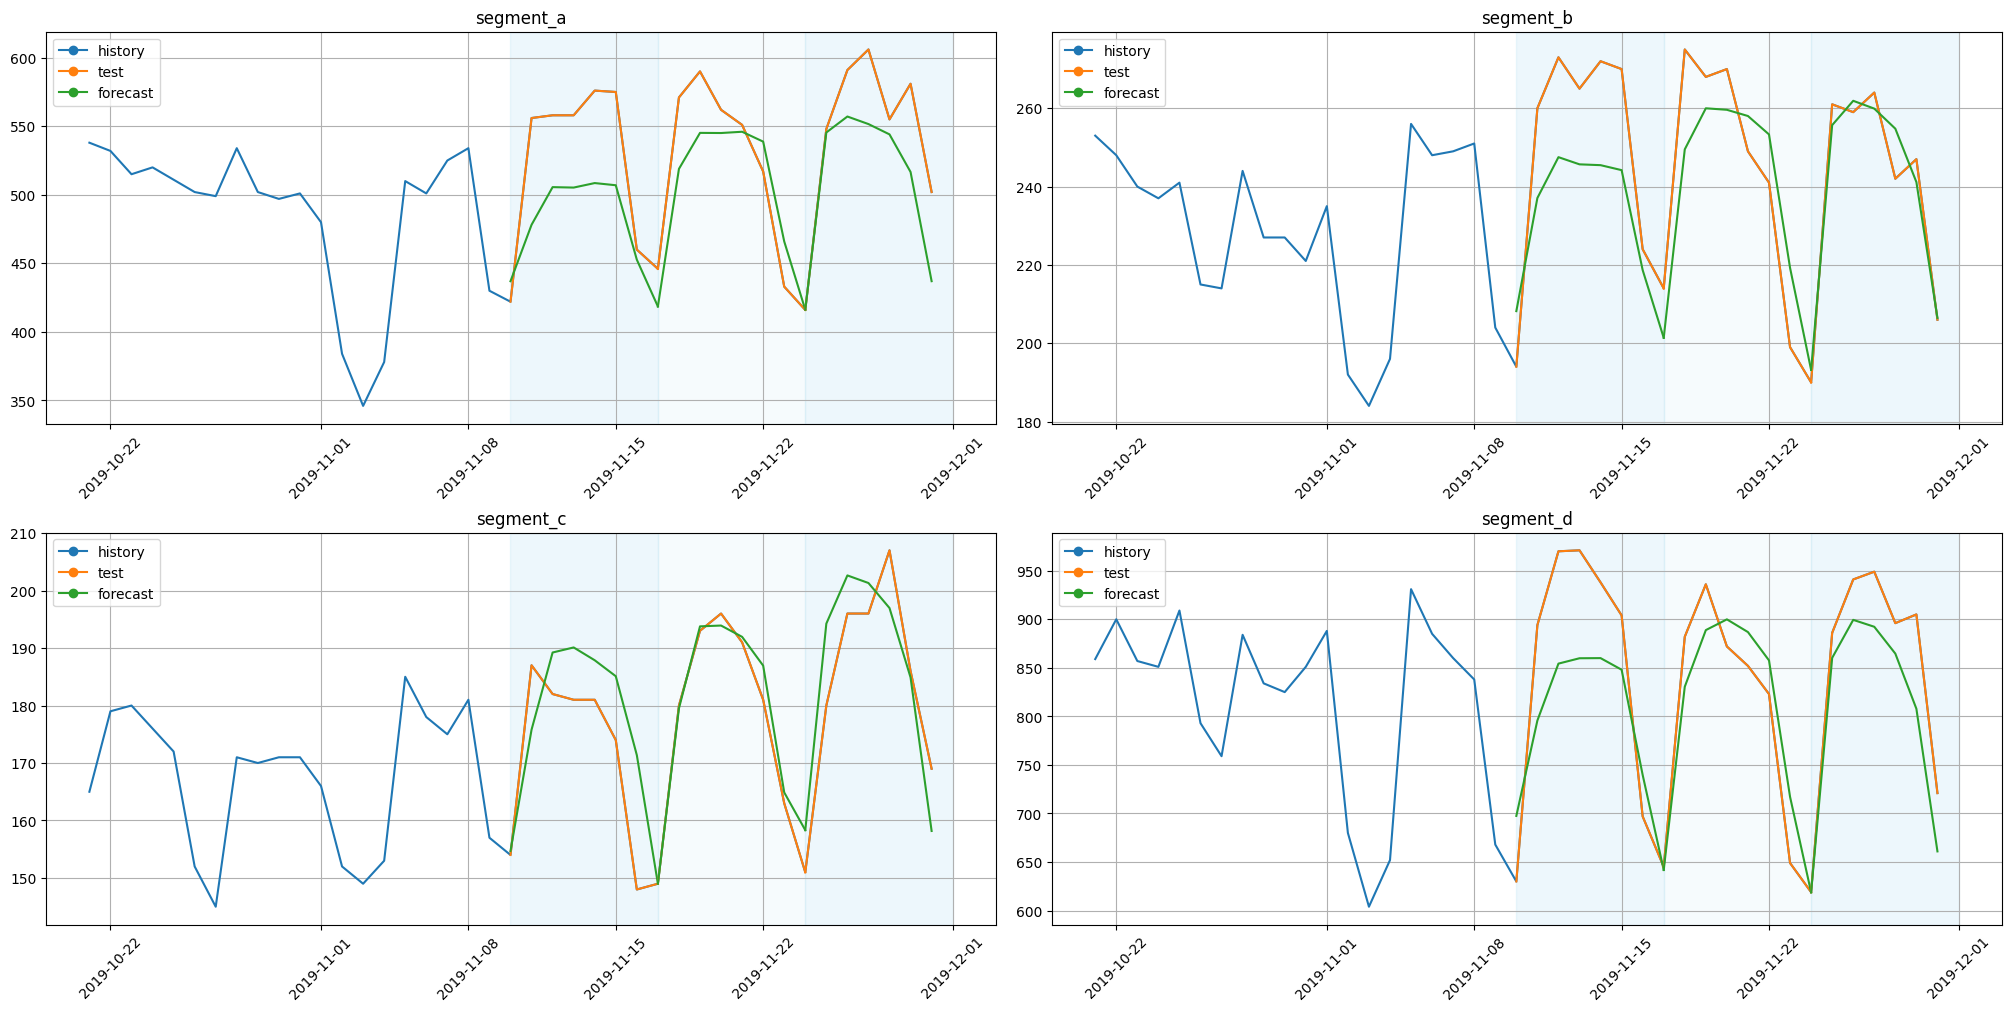

In [ ]:
plot_backtest(forecast_rnn, ts, history_len=20)

### 3.7 N-BEATS Model <a class="anchor" id="section_3_6"></a>

This architecture is based on backward and forward residual links and a deep stack of fully connected layers.

There are two types of models in the library. The `NBeatsGenericModel` class implements a generic deep learning model, while the `NBeatsInterpretableModel` is augmented with certain inductive biases to be interpretable (trend and seasonality).


https://openreview.net/pdf?id=r1ecqn4YwB

In [ ]:
from etna.models.nn import NBeatsGenericModel
from etna.models.nn import NBeatsInterpretableModel # есть еще интерпретируемая версия модели!

In [ ]:
model_nbeats_generic = NBeatsGenericModel(
    input_size=2 * HORIZON,
    output_size=HORIZON,
    loss="smape",
    stacks=30,
    layers=4,
    layer_size=256,
    trainer_params=dict(max_epochs=1000),
    lr=1e-3,
)

pipeline_nbeats_generic = Pipeline(
    model=model_nbeats_generic,
    horizon=HORIZON,
    transforms=[],
)

In [ ]:
metrics_nbeats_generic, forecast_nbeats_generic, _ = pipeline_nbeats_generic.backtest(
    ts, metrics=metrics, n_folds=3, n_jobs=1
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type        | Params
--------------------------------------
0 | model | NBeats      | 206 K 
1 | loss  | NBeatsSMAPE | 0     
--------------------------------------
206 K     Trainable params
0         Non-trainable params
206 K     Total params
0.826     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [ ]:
score = metrics_nbeats_generic["SMAPE"].mean()
print(f"Average SMAPE for N-BEATS Generic: {score:.3f}")

Average SMAPE for N-BEATS Generic: 5.577


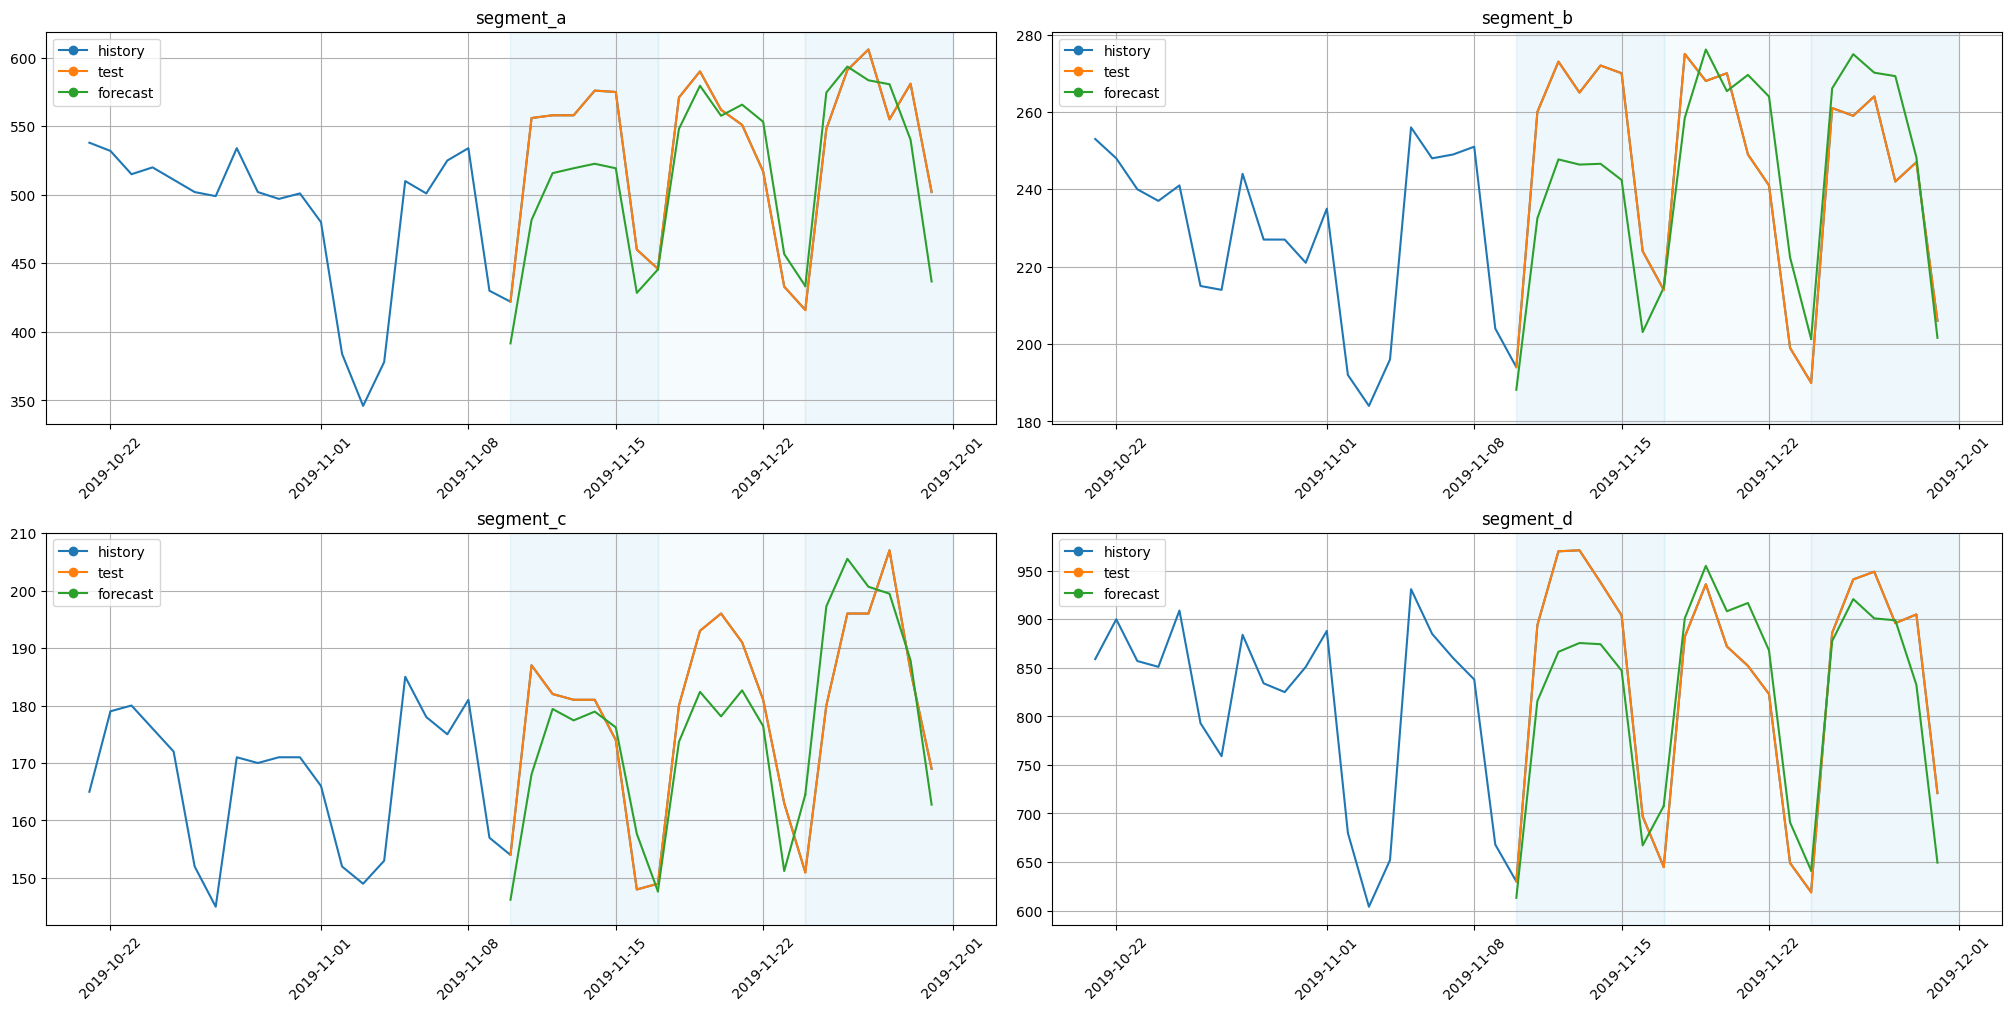

In [ ]:
plot_backtest(forecast_nbeats_generic, ts, history_len=20)